# Reinforcement Learning: DQNs


# Introduction
***

This project is about solving a reinforcement problem with an algorithm so called deep Q-Learning. 


## Deep Q-Network
DQN is introduced in 2 papers, Playing Atari with Deep Reinforcement Learning on NIPS in 2013 and Human-level control through deep reinforcement learning on Nature in 2015. Interestingly, there were only few papers about DRN between 2013 and 2015. I guess that the reason was people couldn’t reproduce DQN implementation without information in Nature version.


## Game Environment

The playbox from `openAI` for developing and comparing reinforcement learning algorithms is the library called `gym`.
This library inclued several environments or test problems that can be solved with reinforcement algorithm. 
It provides easy shared interfaces, which enables to skip the complex manual feature engineering. 


This project captures the learning problem `MountainCar`. 
Here is the challenge that a car, stocked between two hills, need to climb the right hill, but the a single impulse cause a to less momentum. The only way to solve the problem is that the agent drives front and back to generate a stronger momentum. 
Typically, the agent does not know about this approach and how to solve this efficiently.
A Moore, Efficient Memory-Based Learning for Robot Control, PhD thesis, University of Cambridge, 1990. first discribed the problem.

![](pic/mountainCar.png)

This is the `MountainCar` evironment from gym.

In [1]:
import gym
env = gym.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


The spaces for the action is disrcet and there are 3 possible actions availible.
$$
a \in \mathcal{A} = \{0, 1, 2\}
$$


number | action  
-------|-------  
0      | push left
1      | no operation
2      | push right

In [3]:
env.action_space

Discrete(3)

The observation space $\boldsymbol{i}$ is an `2` dimensional vector. The first dimension tells the position of the car and the second the velocity, fall into two intervalls:

$$
\boldsymbol{i} = (i_1, i_2)' \in \mathcal{S} = [-1.2, 0.6] \times [-0.07, 0.07]
$$

number | sate  
-------|-------  
$i_1$  | position
$i_2$  | velocity

In [4]:
print(env.observation_space)
print("Lower bound is :: {}".format(env.observation_space.low))
print("Upper bound is :: {}".format(env.observation_space.high))

Box(2,)
Lower bound is :: [-1.2  -0.07]
Upper bound is :: [0.6  0.07]


## Reward 

The reward is set to be -1 for each time step except the goal position of $0.5$ is reached.
$$
r \in \mathcal{R} = \{-1, 0\}
$$

and adjusted to:
$$
r_t = 
	\begin{cases}
	i_{1t} & \text{if } i_t \neq (0.5, \cdot) \\
	10     & \text{otherwise}
	\end{cases}.
$$

## Terminal State
The terminal state determnines the end of an epsiode and is either when the car is in state $\boldsymbol{i}_{500}$ or in the state $\boldsymbol{i}_t = (0.5, i_{t2})$ with $t \leq 200$.

# Evaluation the Training
***

## Setup

In [3]:
import deepQLearningSimple as dql
import gym
from keras.models import load_model 
from gym.envs.classic_control.mountain_car import MountainCarEnv
from gym.wrappers.time_limit import TimeLimit

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json

%matplotlib inline
sns.set_style("darkgrid")

In [4]:
def loadHistory(path):
    f = open(path + "history.json")
    return json.loads(f.read())

# Load version simple
path = "data/history/version_simple_v0/"
history = loadHistory(path)

# load version simple with max memory
path = "data/history/version_simple_max_memory/"
history2 = loadHistory(path)

print("History records: %s" %[i for i in history.keys()])

# num of episodes
episodes = 500

History records: ['mean_q_values', 'episode', 'reward', 'position', 'cum_win', 'steps']


## Wins

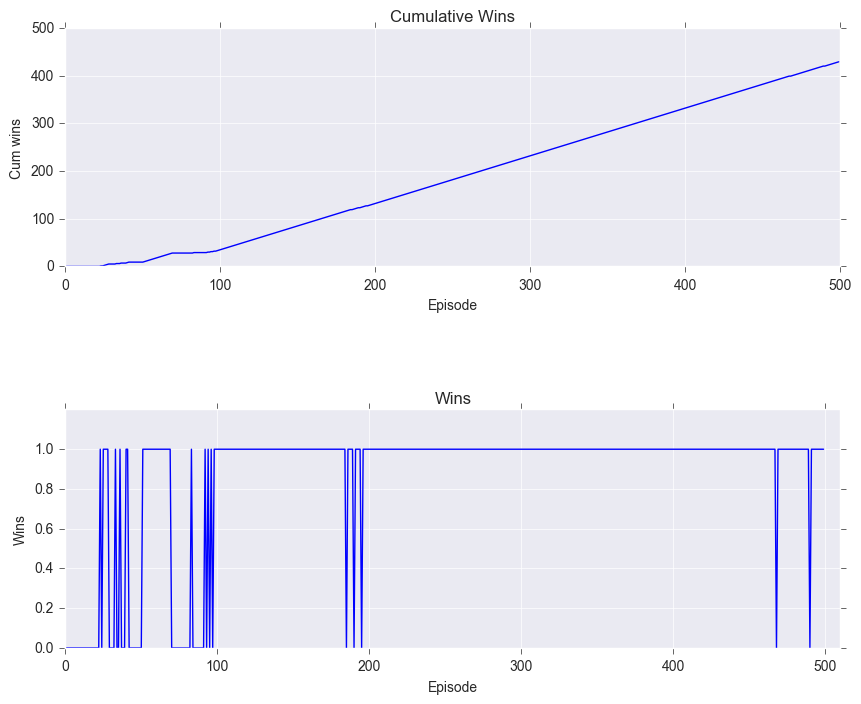

In [328]:
plt.figure(1, figsize= [10,8])


plt.subplot(211)
wins = history["cum_win"]
plt.plot(wins)
plt.xlabel('Episode')
plt.ylabel('Cum wins')
plt.title('Cumulative Wins')
plt.ylim(0, episodes)
plt.xlim(0, episodes)

plt.subplot(212)
wins = list(map(lambda x: 1 if x >=0.5 else 0, history['position']["max_position"]))
plt.plot(wins, "-", marker= "")
plt.xlabel('Episode')
plt.ylabel('Wins')
plt.title('Wins')
plt.ylim(0, 1.2)
plt.xlim(0, episodes+10)
plt.subplots_adjust(hspace = 0.6)


plt.savefig('pic/simple_version_cum_win.png')


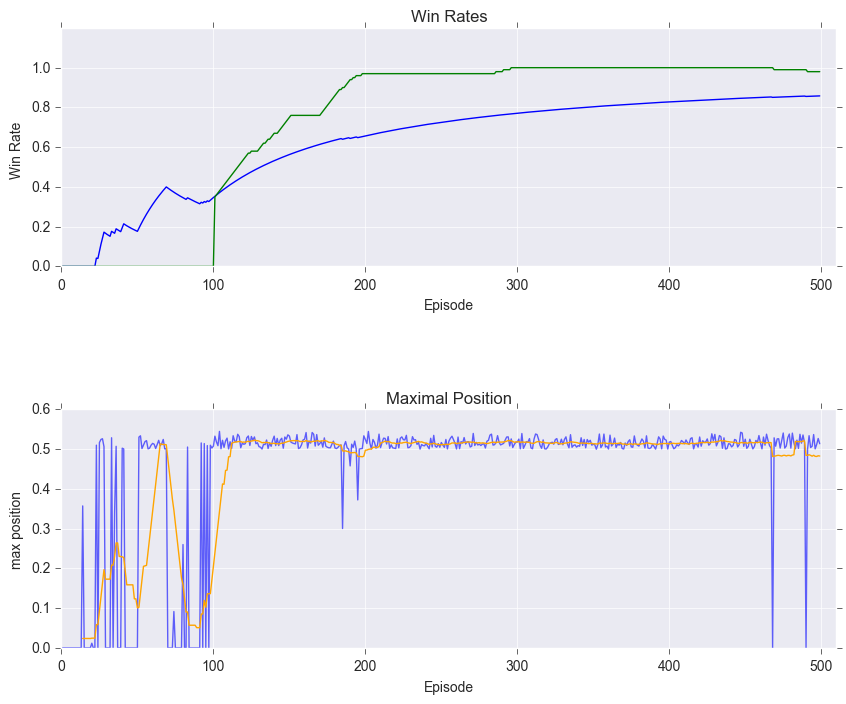

In [344]:
# Wins
def movingRate(lag):
    idx = range(len(history["cum_win"]) -1 )
    lag
    out = [ ((history["cum_win"][i + lag])- history["cum_win"][i]) / lag for i in idx if i < (500 -1 - lag)]
    return list(np.append(np.zeros(lag +1), out))
    

cum_win_rate_moving = movingRate(100)
cum_win_rate = list(map(lambda a,b: (round(a / b, 4)), history["cum_win"], history["episode"]))

plt.figure(1, figsize= [10,8])
plt.subplot(211)
plt.plot(cum_win_rate, label = "Avg Wins")
plt.plot(cum_win_rate_moving, label = "MA Wins")
plt.xlabel('Episode')
plt.ylabel('Win Rate ')
plt.title('Win Rates')
plt.ylim(0, 1.2)
plt.xlim(0, episodes+10)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.subplot(212)
max_posision = history["position"]["max_position"]
max_posision = pd.Series(max_posision)
ma = max_posision.rolling(15).mean()
plt.plot(max_posision, alpha = 0.6, label = "Max Position")
plt.plot(ma, "orange", label = "MA Max Position")
plt.xlabel('Episode')
plt.ylabel('max position')
plt.title("Maximal Position")
plt.xlim(0, episodes +10)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(hspace = 0.6)

plt.savefig('pic/winRatesAndMaxPosition.png')

plt.show()

In [65]:
for i,j in zip([1, 100, 200, 450],[100, 500, 450, 500]):
    print("Win rate from game {} to game {} is {}".format(history["episode"][i-1], history["episode"][j-1],
                                                     ( (history["cum_win"][j-1]) - history["cum_win"][i-1])  / (j-i)))

Win rate from game 1 to game 100 is 0.3434343434343434
Win rate from game 100 to game 500 is 0.9875
Win rate from game 200 to game 450 is 1.0
Win rate from game 450 to game 500 is 0.96


In [363]:
# Models away from loss:
for i,j in zip([196],[468,]):
    print("Win rate from game {} to game {} is {}".format(history["episode"][i-1], history["episode"][j-1],
                                                     ( (history["cum_win"][j-1]) - history["cum_win"][i-1])  / (j-i)))

Win rate from game 196 to game 468 is 1.0


## Return and Action Value

Best Episode :: 191 with max mean Q value :: 0.02671215869486332 


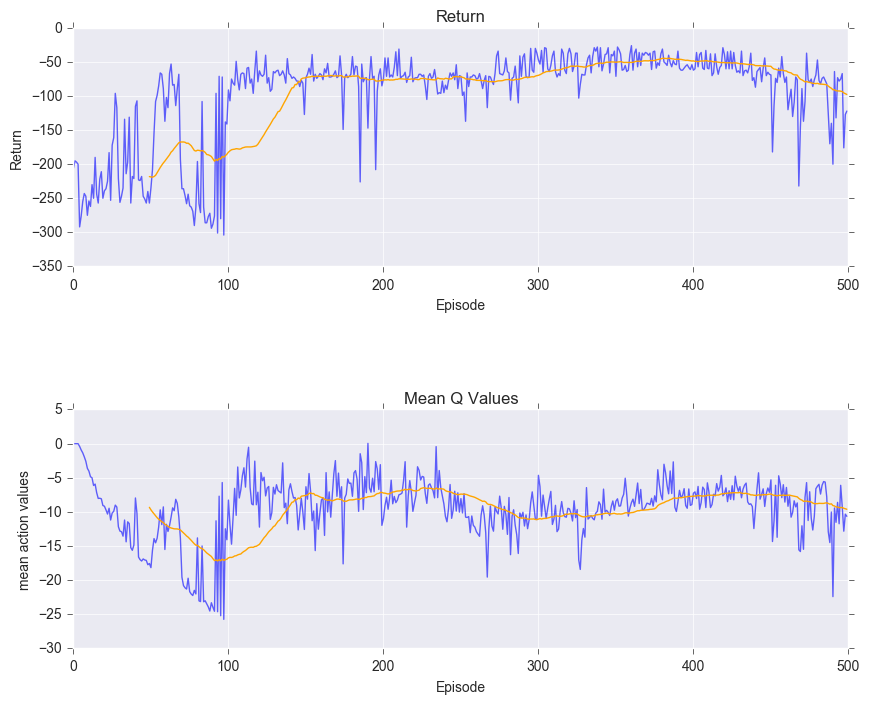

In [343]:
plt.figure(1, figsize= [10,8])


plt.subplot(211)
reward = history["reward"]
reward = pd.Series(reward)
ma = reward.rolling(50).mean()
plt.plot(reward, alpha = 0.6, label = "Return")
plt.plot(ma, "orange", label = "MA Return")
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title("Return")
plt.xlim(0,episodes)
#plt.legend(bbox_to_anchor=(1, 0.2), borderaxespad=0.)

plt.subplot(212)
mean_action_values = history["mean_q_values"]
mean_action_values = pd.Series(mean_action_values)
ma = mean_action_values.rolling(50).mean()
plt.plot(mean_action_values, alpha = 0.6, label = "Mean Q Values")
plt.plot(ma, "orange", label = "MA Mean Q Values")
plt.xlabel('Episode')
plt.ylabel('mean action values')
plt.title("Mean Q Values")
plt.xlim(0, episodes)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(hspace = 0.6)


plt.savefig('pic/returnAndQvalues.png')

best_episode = np.argmax(history["mean_q_values"])
print("Best Episode :: {} with max mean Q value :: {} ".format(history["episode"][best_episode], history["mean_q_values"][best_episode]) )

## Position

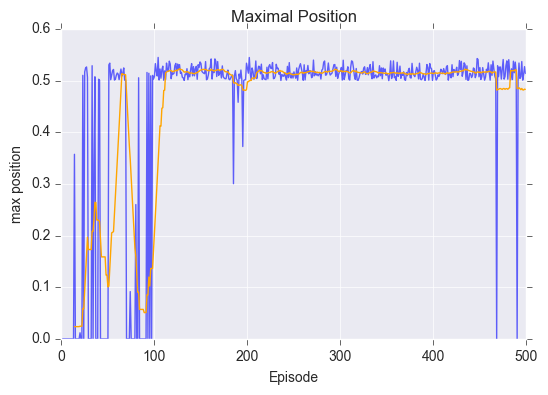

In [25]:
max_posision = history["position"]["max_position"]
max_posision = pd.Series(max_posision)
ma = max_posision.rolling(15).mean()
plt.plot(max_posision, alpha = 0.6)
plt.plot(ma, "orange")
plt.xlabel('Episode')
plt.ylabel('max position')
plt.title("Maximal Position")
plt.xlim(0,episodes)
plt.show()

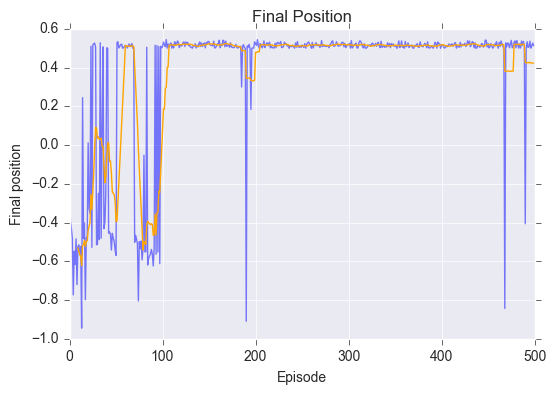

In [26]:
final_position = history["position"]["final_position"]
final_position = pd.Series(final_position)
ma = final_position.rolling(10).mean()
plt.plot(final_position, alpha = 0.5)
plt.plot(ma, "orange")
plt.xlabel('Episode')
plt.ylabel('Final position')
plt.title("Final Position")
plt.xlim(0,episodes)
plt.show()

# Steps per won game

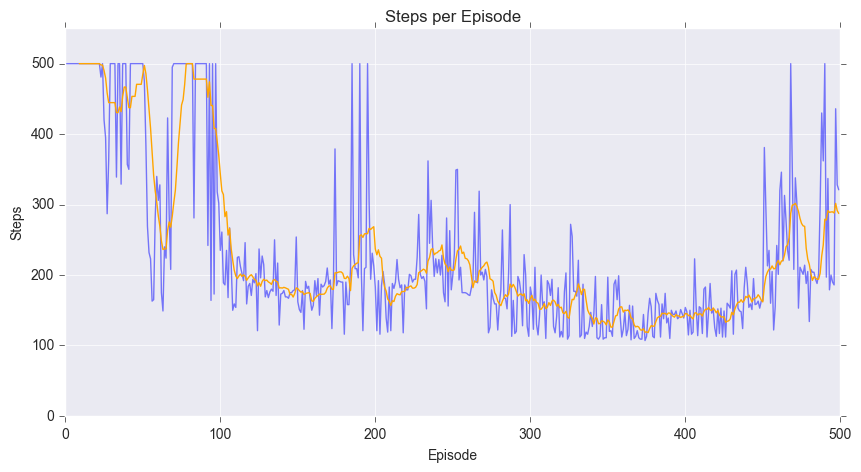

In [373]:
plt.figure(1, figsize= [10,5])
steps = history["steps"]
#steps = [step for step in steps if step < 500]
steps = pd.Series(steps)
ma = steps.rolling(10).mean()
plt.plot(steps, alpha = 0.5)
plt.plot(ma, "orange")
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.ylim(0, 550)
plt.title('Steps per Episode')

plt.savefig('pic/stepPerEpisode.png')

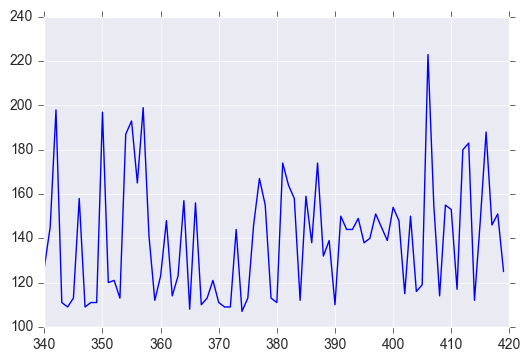

In [390]:
plt.plot(steps[340:420])